In [4]:
from tensorflow.keras.utils import Sequence
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau #import Cllback function

import numpy as np
import matplotlib.pyplot as plt

In [5]:
data=r'D:/Safril/Dokumen/Pascasarjana/ITS/Semester 1/KBJ/FP/program/cnn-forgery/aug_included'

In [6]:
batch_size = 32
img_height = 224
img_width = 224

In [7]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen= ImageDataGenerator(
                rescale=1./255
                # zoom_range=0.15, 
                # width_shift_range=0.2,
                # shear_range=0.15
                )
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
#setting train test split
train = train_datagen.flow_from_directory(
        data,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        subset='training' )

test = test_datagen.flow_from_directory(
        data,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False )

Found 7359 images belonging to 2 classes.
Found 7359 images belonging to 2 classes.


In [9]:
classess = train.num_classes
classess

2

In [10]:
VGG_model =VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

In [11]:
for i in VGG_model.layers:
    i.trainable = False

In [12]:
def main_model(tl_model,classess):
    m_model=tl_model.output
    m_model=GlobalAveragePooling2D()(m_model)
    m_model=Dense(1024,activation='relu')(m_model)
    m_model=Dense(1024,activation='relu')(m_model)
    m_model=Dense(512,activation='relu')(m_model)
    m_model=Dense(256,activation='relu')(m_model)
    m_model=Dense(128,activation='relu')(m_model)
    m_model=Dense(classess,activation='sigmoid')(m_model)
    return m_model



In [13]:
combining_model_VGG16=main_model(VGG_model,classess)


In [14]:
model_VGG16=Model(inputs=VGG_model.input, outputs=combining_model_VGG16)

In [15]:
model_VGG16.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_VGG16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
earlystop=EarlyStopping(patience=10)#Monitor the performence. If it dips, then stop training
learning_rate_reduce= ReduceLROnPlateau(monitor='val_accuracy',min_lr=0.001)#Change learning rate if not performing good enough
callbacks=[earlystop,learning_rate_reduce]

In [17]:
history=model_VGG16.fit(train,validation_data=test,epochs=5)

Epoch 1/5
230/230 [==============================] - 7159s 31s/step - loss: 0.6850 - accuracy: 0.5660 - val_loss: 0.6710 - val_accuracy: 0.5937
Epoch 2/5
230/230 [==============================] - 14790s 65s/step - loss: 0.6500 - accuracy: 0.6071 - val_loss: 0.5851 - val_accuracy: 0.6740
Epoch 3/5
230/230 [==============================] - 5030s 22s/step - loss: 0.5651 - accuracy: 0.6890 - val_loss: 0.5722 - val_accuracy: 0.6864
Epoch 4/5
230/230 [==============================] - 6025s 26s/step - loss: 0.4801 - accuracy: 0.7511 - val_loss: 0.4331 - val_accuracy: 0.7854
Epoch 5/5
230/230 [==============================] - 5525s 24s/step - loss: 0.4656 - accuracy: 0.7622 - val_loss: 0.4146 - val_accuracy: 0.7888


In [18]:
model_VGG16.save('VGG16_project1.h5')

In [19]:
test_score=model_VGG16.evaluate(test)

230/230 [==============================] - 2332s 10s/step - loss: 0.4146 - accuracy: 0.7888


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

target_names=[]
for key in train.class_indices:
    target_names.append(key)

In [21]:
def plot_cfx(cm, classess, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks=np.arange(len(classess))
    plt.xticks(tick_marks, classess, rotation=45)
    plt.yticks(tick_marks, classess)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print('Confusion Matrix dengan Normalisasi')
    else:
        print('Confusion Matrix dengan Tanpa Normalisasi')
    thresh=cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                 horizontalalignment='center',
                 color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
        

230/230 [==============================] - 2341s 10s/step
confusion Matrix
Confusion Matrix dengan Tanpa Normalisasi


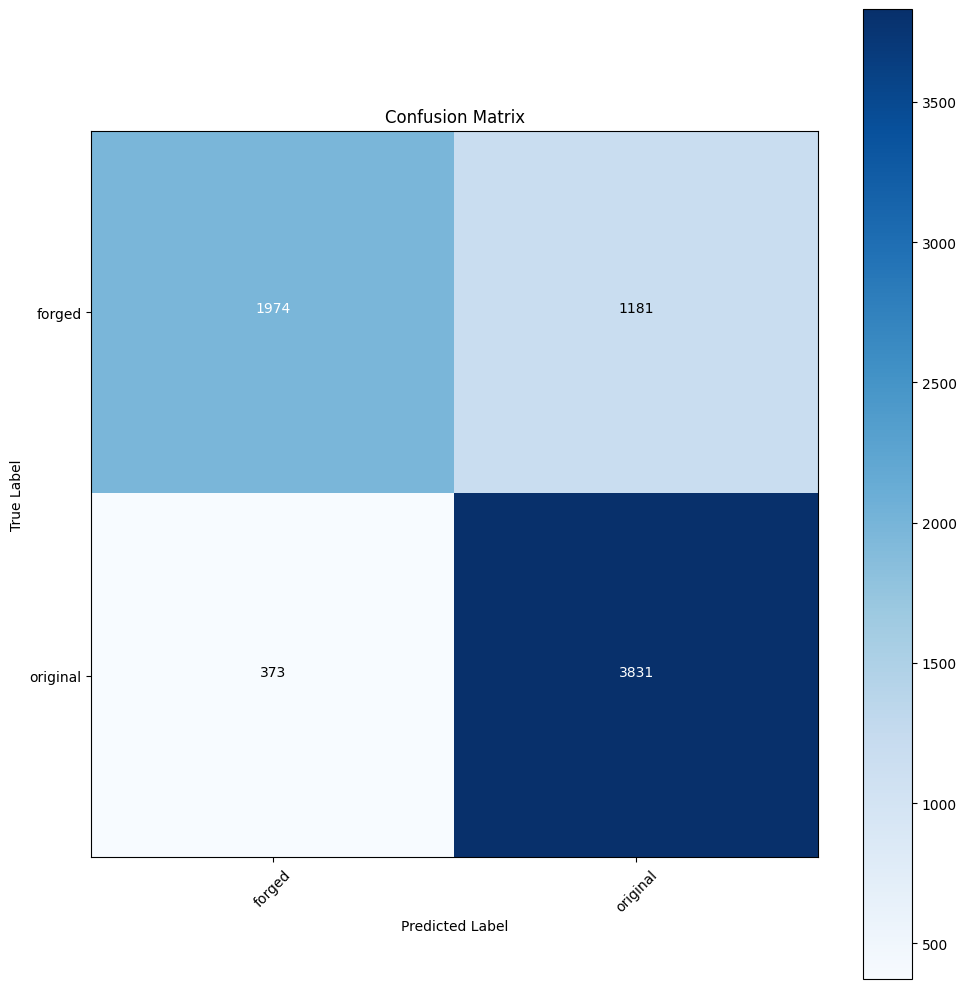

In [22]:
#Confusion Matrix dan Classification Report
Y_pred = model_VGG16.predict(test)
y_pred = np.argmax(Y_pred, axis=-1)
print('confusion Matrix')
cm=confusion_matrix(test.classes, y_pred)

plot_cfx(cm, target_names, title='Confusion Matrix')

In [23]:
print('Classification Report')
print(classification_report(test.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      forged       0.84      0.63      0.72      3155
    original       0.76      0.91      0.83      4204

    accuracy                           0.79      7359
   macro avg       0.80      0.77      0.77      7359
weighted avg       0.80      0.79      0.78      7359



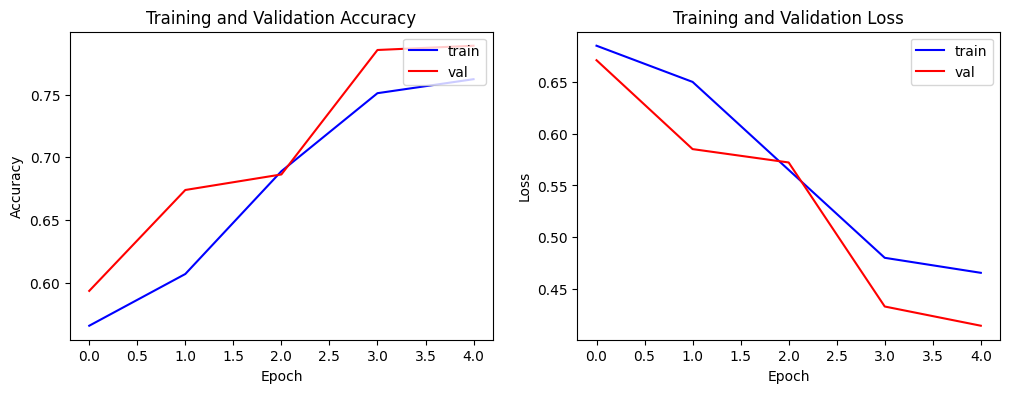

In [24]:
train_accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
train_loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(train_accuracy))
plt.figure(figsize=(12,4))

#plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs,train_accuracy,'b', label='Training Accuracy')
plt.plot(epochs,val_accuracy,'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','val'], loc='upper right')

#plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs,train_loss,'b', label='Training Loss')
plt.plot(epochs,val_loss,'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'], loc='upper right')

plt.show()

In [25]:
labels=train.class_indices
final_labels={v: k for k, v in labels.items()}

final_labels

{0: 'forged', 1: 'original'}

In [26]:
from tensorflow.keras.models import load_model
import ast
from tensorflow.keras.preprocessing import image

In [31]:
def prediksi(imgname, from_test_dir):
    test_image=image.load_img(imgname, target_size=(224,224))

    plt.imshow(test_image)
    plt.show()

    test_image=np.asarray(test_image)
    test_image=np.expand_dims(test_image, axis=0)
    result=model_VGG16.predict(test_image)

    result_dict=dict()
    for key in list(final_labels.keys()):
        result_dict[final_labels[key]] = result[0][key]
    
    sorted_result={k: v for k, v in sorted(result_dict.items(),key=lambda item:item[1], reverse=True)}

    if not from_test_dir:
        print('='*50)
        for label in sorted_result.keys():
            print('{}:{}%'.format(label, sorted_result[label]*100))
    
    final_result=dict()
    final_result[list(sorted_result.keys())[0]]=sorted_result[list(sorted_result.keys())[0]]*100

    return final_result


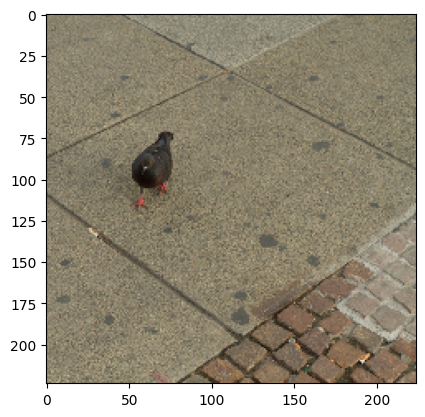

1/1 [==============================] - 0s 293ms/step
original:100.0%
forged:2.1818247208926778e-08%
Hasil Prediksi Gambar =  {'original': 100.0}


In [35]:
#Coba prediksi gambar yang Original
hasil1=prediksi(r'D:/Safril/Dokumen/Pascasarjana/ITS/Semester 1/KBJ/FP/program/cnn-forgery/aug_included/original/050_O.png',False)
print('Hasil Prediksi Gambar = ',hasil1)

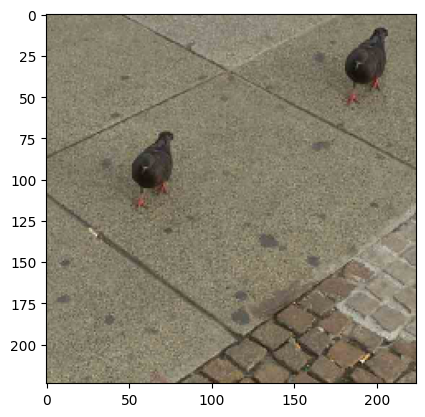

1/1 [==============================] - 0s 290ms/step
forged:100.0%
original:8.337255984407668e-30%
Hasil Prediksi Gambar =  {'forged': 100.0}


In [37]:
#Coba prediksi gambar yang Original
hasil2=prediksi(r'D:/Safril/Dokumen/Pascasarjana/ITS/Semester 1/KBJ/FP/program/cnn-forgery/aug_included/forged/050_F_JC2.jpg',False)
print('Hasil Prediksi Gambar = ',hasil2)